In [1]:
import sys
import os
import numpy as np
sys.path.append('..')
from src import NeuralNet
from src import train as fit
from src import make_directory 
from models import load_model
from data import load_data
from six.moves import cPickle
np.random.seed(247) # for reproducibility

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
%matplotlib inline
from scipy.misc import imresize

from lasagne import layers, nonlinearities, updates, objectives, init 
from lasagne.layers import get_output, get_output_shape, get_all_params
import theano.tensor as T
import theano
np.random.seed(247) # for reproducibility

Using gpu device 0: GeForce GTX 980 (CNMeM is disabled, CuDNN 4007)


In [2]:
name = 'MotifSimulation_categorical'
datapath = '/home/peter/Data/SequenceMotif'
filepath = os.path.join(datapath, 'N=100000_S=200_M=30_G=20_data.pickle')
train, valid, test = load_data(name, filepath)
shape = (None, train[0].shape[1], train[0].shape[2], train[0].shape[3])
num_labels = np.max(train[1])+1

loading data from: /home/peter/Data/SequenceMotif/N=100000_S=200_M=30_G=20_data.pickle
loading train data
loading cross-validation data
loading test data


In [3]:
model_name = "categorical_genome_motif_model"
nnmodel = NeuralNet(model_name, shape, num_labels)

In [4]:
outputname = 'over-fit1'
datapath = make_directory(datapath, 'images')
filepath = os.path.join(datapath, outputname)

In [5]:
nnmodel = fit.train_minibatch(nnmodel, train, valid, batch_size=100, num_epochs=500, 
                        patience=3, verbose=1, filepath=filepath)

Epoch 1 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.84293 -- accuracy=76.29%  
  valid loss:		0.18185
  valid accuracy:	0.99489+/-0.00439
  valid auc-roc:	0.99521+/-0.00944
  valid auc-pr:		0.88490+/-0.25326
saving model parameters to: /home/peter/Data/SequenceMotif/images/over-fit1_epoch_0.pickle
Epoch 2 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.17472 -- accuracy=95.01%  
  valid loss:		0.11226
  valid accuracy:	0.99665+/-0.00283
  valid auc-roc:	0.99738+/-0.00736
  valid auc-pr:		0.92671+/-0.20882
saving model parameters to: /home/peter/Data/SequenceMotif/images/over-fit1_epoch_1.pickle
Epoch 3 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.11348 -- accuracy=96.63%  
  valid loss:		0.09998
  valid accuracy:	0.99705+/-0.00259
  valid auc-roc:	0.99872+/-0.00327
  valid auc-pr:		0.93492+/-0.19760
saving model parameters to: /home/peter/Data/SequenceMotif/images/over-fit1_epoch_2.pickle
Epoch 4 out of 5

In [7]:
def fig_options(plt, options):
    if 'figsize' in options:
        fig = plt.gcf()
        fig.set_size_inches(options['figsize'][0], options['figsize'][1], forward=True)
    if 'ylim' in options:
        plt.ylim(options['ylim'][0],options['ylim'][1])
    if 'yticks' in options:
        plt.yticks(options['yticks'])
    if 'xticks' in options:
        plt.xticks(options['xticks'])
    if 'labelsize' in options:        
        ax = plt.gca()
        ax.tick_params(axis='x', labelsize=options['labelsize'])
        ax.tick_params(axis='y', labelsize=options['labelsize'])
    if 'axis' in options:
        plt.axis(options['axis'])
    if 'xlabel' in options:
        plt.xlabel(options['xlabel'], fontsize=options['fontsize'])
    if 'ylabel' in options:
        plt.ylabel(options['ylabel'], fontsize=options['fontsize'])
    if 'linewidth' in options:
        plt.rc('axes', linewidth=options['linewidth'])
        
def get_feature_maps(layer, input_var, X, batch_size=500):
    """get the feature maps of a given convolutional layer"""
    
    num_data = len(X)
    feature_maps = theano.function([input_var], layers.get_output(layer), allow_input_downcast=True)
    map_shape = get_output_shape(layer)

    # get feature maps in batches for speed (large batches may be too much memory for GPU)
    batch_size=500
    num_batches = num_data // batch_size
    shape = list(map_shape)
    shape[0] = num_data
    fmaps = np.empty(tuple(shape))
    for i in range(num_batches):
        index = range(i*batch_size, (i+1)*batch_size)    
        fmaps[index] = feature_maps(X[index])

    # get the rest of the feature maps
    excess = num_data-num_batches*batch_size
    if excess:
        index = range(num_data-excess, num_data)  
        fmaps[index] = feature_maps(X[index])

    return fmaps

def subplot_grid(nrows, ncols):
    grid= mpl.gridspec.GridSpec(nrows, ncols)
    grid.update(wspace=0.2, hspace=0.2, left=0.1, right=0.2, bottom=0.1, top=0.2) 
    return grid

def tSNE_plot(vis_data, labels):
    """scatter plot of tSNE 2D projections, with a color corresponding to labels"""
    num_labels = max(labels)+1
    vis_x = vis_data[:,0]
    vis_y = vis_data[:,1]
    plt.figure(figsize = (10,10))
    fig = plt.gcf()
    fig.set_size_inches(50, 50, forward=True)
    plt.scatter(vis_x, vis_y, c=labels, cmap=plt.cm.get_cmap("jet", num_labels),  edgecolor = 'none')
    plt.axis('off')
    return plt


def tSNE_embed_plot(vis_data, X_train, y_train):
    """image embeded with original images at locations given by 
    2D tSNE projection coordinates """

    num_labels = max(y_train)+1
    
    # setup a colormap
    colormap = cm.gist_rainbow(np.linspace(0, 255, num_labels).astype(int))

    # rescale embedding coordinates within [0, 1]
    vis_data -= np.min(vis_data)
    vis_data /= np.max(vis_data)

    # create canvas to embed images
    canvas_size = 3000
    canvas = np.zeros((canvas_size, canvas_size, 3)).astype(np.uint8)

    # set image_size, will downsample if smaller than 28
    image_size = 28
    scale = canvas_size-image_size

    # embed images onto canvas
    num_samples = 50000
    for i in range(num_samples):
        pos = np.ceil(vis_data[i,:]*scale).astype(int)
        downsample_img =imresize(np.reshape(X_train[i], (28,28)),(image_size, image_size))
        for j in range(3):
            canvas[pos[0]:pos[0]+image_size,pos[1]:pos[1]+image_size,j] = downsample_img*colormap[y_train[i]][j]

    plt.figure(figsize = (10,10))
    fig = plt.gcf()
    fig.set_size_inches(15, 15, forward=True)
    plt.imshow(np.invert(canvas), cmap='gray', interpolation='nearest')
    plt.axis('off')
    return plt


def get_weights(layer, convert_pwm=0):
    W =  np.squeeze(layer.W.get_value())
    W_norm = W
    if convert_pwm == 1:
        for i in range(len(W)):
            #weights = np.exp(W[i])
            MIN = np.min(W[i])
            weights = W[i] - MIN
            Z = np.sum(weights, axis=0)
            weights /= np.tile(Z, (W[i].shape[0],1))
            W_norm[i] = weights
    return W_norm

def plot_conv_weights(W, options):
    num_filters = W.shape[0]
    nrows = np.ceil(np.sqrt(num_filters)).astype(int)
    ncols = nrows
    plt.figure()
    grid = subplot_grid(nrows, ncols)
    for i in range(num_filters):
        plt.subplot(grid[i])
        plt.imshow(W[i], cmap='hot_r', interpolation='nearest')
        fig_options(plt, options)
    return plt

def batch_generator(X, y, batch_size=128, shuffle=True):
    """python generator to get a randomized minibatch"""
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx+batch_size]
        else:
            excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt].astype('float32'), y[excerpt].astype('int32')


def get_class_activation(fmaps, y, batch_size=512):
    fmaps = np.squeeze(fmaps)
    mean_activation = []
    std_activation = []
    for i in range(max(y)+1):
        index = np.where(y == i)[0]
        mean_activation.append(np.mean(fmaps[index], axis=0))
        std_activation.append(np.std(fmaps[index], axis=0))
    return np.array(mean_activation), np.array(std_activation)


def plot_mean_activations(mean_activation, options):
    num_labels = len(mean_activation)
    nrows = np.ceil(np.sqrt(num_labels)).astype(int)
    ncols = nrows

    plt.figure()
    grid = subplot_grid(nrows, ncols)
    for i in range(num_labels):
        plt.subplot(grid[i])
        plt.plot(mean_activation[i].T)
        fig_options(plt, options)
    return plt


def plot_conv_weights(W, options):
    num_filters = W.shape[0]
    nrows = np.ceil(np.sqrt(num_filters)).astype(int)
    ncols = nrows
    plt.figure()
    grid = subplot_grid(nrows, ncols)
    for i in range(num_filters):
        plt.subplot(grid[i])
        plt.imshow(W[i], cmap='hot_r', interpolation='nearest')
        fig_options(plt, options)
    return plt
    
def tSNE_plot(vis_data, labels):
    """scatter plot of tSNE 2D projections, with a color corresponding to labels"""
    num_labels = max(labels)+1
    vis_x = vis_data[:,0]
    vis_y = vis_data[:,1]
    plt.figure(figsize = (10,10))
    fig = plt.gcf()
    fig.set_size_inches(50, 50, forward=True)
    plt.scatter(vis_x, vis_y, c=labels, cmap=plt.cm.get_cmap("jet", num_labels),  edgecolor = 'none')
    plt.axis('off')
    return plt



def seq_logo(pwm, height=100, width=200, norm=0, rna=1, filepath='.'):
    """generate a sequence logo from a pwm"""
    
    def load_alphabet(filepath, rna):
        """load images of nucleotide alphabet """
        df = pd.read_table(os.path.join(filepath, 'A.txt'), header=None);
        A_img = df.as_matrix()
        A_img = np.reshape(A_img, [72, 65, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'C.txt'), header=None);
        C_img = df.as_matrix()
        C_img = np.reshape(C_img, [76, 64, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'G.txt'), header=None);
        G_img = df.as_matrix()
        G_img = np.reshape(G_img, [76, 67, 3], order="F").astype(np.uint8)

        if rna == 1:
            df = pd.read_table(os.path.join(filepath, 'U.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [74, 57, 3], order="F").astype(np.uint8)
        else:
            df = pd.read_table(os.path.join(filepath, 'T.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [72, 59, 3], order="F").astype(np.uint8)

        return A_img, C_img, G_img, T_img


    def get_nt_height(pwm, height, norm):
        """get the heights of each nucleotide"""

        def entropy(p):
            """calculate entropy of each nucleotide"""
            s = 0
            for i in range(4):
                if p[i] > 0:
                    s -= p[i]*np.log(p[i])
            return s

        num_nt, num_seq = pwm.shape
        heights = np.zeros((num_nt,num_seq));
        for i in range(num_seq):
            if norm == 1:
                total_height = height
            else:
                total_height = (2 - entropy(pwm[:, i]))*height/2;
            heights[:,i] = np.floor(pwm[:,i]*total_height);

        return heights.astype(int)

    
    # get the alphabet images of each nucleotide
    A_img, C_img, G_img, T_img = load_alphabet(filepath='.', rna=1)
    
    
    # get the heights of each nucleotide
    heights = get_nt_height(pwm, height, norm)

    # resize nucleotide images for each base of sequence and stack
    num_nt, num_seq = pwm.shape
    nt_width = np.floor(width/num_seq).astype(int)
    logo = np.ones((height, width, 3)).astype(int)*255;
    for i in range(num_seq):
        remaining_height = height;
        nt_height = np.sort(heights[:,i]);
        index = np.argsort(heights[:,i])

        
        for j in range(num_nt):
            # resized dimensions of image
            if nt_height[j] > 0:
                resize = (nt_height[j],nt_width)
                if index[j] == 0:
                    nt_img = imresize(A_img, resize)
                elif index[j] == 1:
                    nt_img = imresize(C_img, resize)
                elif index[j] == 2:
                    nt_img = imresize(G_img, resize)
                elif index[j] == 3:
                    nt_img = imresize(T_img, resize)

                # determine location of image
                height_range = range(remaining_height-nt_height[j], remaining_height)
                width_range = range(i*nt_width, i*nt_width+nt_width)

                # 'annoying' way to broadcast resized nucleotide image
                for k in range(3):
                    for m in range(len(width_range)):
                        logo[height_range, width_range[m],k] = nt_img[:,m,k];

                remaining_height -= nt_height[j]

    return logo.astype(np.uint8)


def plot_conv_filter(plt, pwm, height=200, bp_width=100, norm=0, rna=1, adjust=-1, filepath='.', showbar=0):
    num_seq = pwm.shape[1]
    width = bp_width*num_seq

    logo = seq_logo(pwm, height, width, norm, rna, filepath)
    
    fig, axes = plt.subplots(nrows=2, ncols=1)
    axes[0].imshow(logo, extent=[bp_width*2, width+bp_width, 0, height])
    axes[0].set_axis_off()
    im = axes[1].imshow(pwm, cmap='jet', vmin=0, vmax=1, interpolation='none') 
    axes[1].set_axis_off()
    fig.subplots_adjust(bottom=adjust)
    if showbar == 1:
        cbar_ax = fig.add_axes([.85, 0.05, 0.05, 0.45])
        cb = fig.colorbar(im, cax=cbar_ax, ticks=[0, 0.5, 1])
        cb.ax.tick_params(labelsize=16)
    return fig


def seq_logo2(pwm, height=100, width=200, norm=0, rna=1, filepath='.'):
    """generate a sequence logo from a pwm"""
    
    def load_alphabet(filepath, rna):
        """load images of nucleotide alphabet """
        df = pd.read_table(os.path.join(filepath, 'A.txt'), header=None);
        A_img = df.as_matrix()
        A_img = np.reshape(A_img, [72, 65, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'C.txt'), header=None);
        C_img = df.as_matrix()
        C_img = np.reshape(C_img, [76, 64, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'G.txt'), header=None);
        G_img = df.as_matrix()
        G_img = np.reshape(G_img, [76, 67, 3], order="F").astype(np.uint8)

        if rna == 1:
            df = pd.read_table(os.path.join(filepath, 'U.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [74, 57, 3], order="F").astype(np.uint8)
        else:
            df = pd.read_table(os.path.join(filepath, 'T.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [72, 59, 3], order="F").astype(np.uint8)

        return A_img, C_img, G_img, T_img


    def get_nt_height(pwm, height, norm):
        """get the heights of each nucleotide"""

        def entropy(p):
            """calculate entropy of each nucleotide"""
            s = 0
            for i in range(4):
                if p[i] > 0:
                    s -= p[i]*np.log(p[i])
            return s

        num_nt, num_seq = pwm.shape
        heights = np.zeros((num_nt,num_seq))
        for i in range(num_seq):
            if norm == 1:
                total_height = height
            else:
                total_height = (2 - entropy(np.abs(pwm[:, i])))*height
            heights[:,i] = np.floor(np.abs(pwm[:,i])*total_height);
            

        return heights.astype(int)

    
    # get the alphabet images of each nucleotide
    A_img, C_img, G_img, T_img = load_alphabet(filepath='.', rna=1)
    
    
    # get the heights of each nucleotide
    heights = get_nt_height(pwm, height, norm)

    # resize nucleotide images for each base of sequence and stack
    num_nt, num_seq = pwm.shape
    nt_width = np.floor(width/num_seq).astype(int)
    logo = np.ones((2*height, width, 3)).astype(int)*255;
    sign = np.sign(pwm)
    for i in range(num_seq):
        pos_index = np.where(sign[:,i]> 0)[0]
        nt_height = np.sort(heights[pos_index,i]);
        index = pos_index[np.argsort(heights[pos_index,i])]
        remaining_height = height;
        
        for j in range(len(pos_index)):
            # resized dimensions of image
        
            if nt_height[j] > 0:
                resize = (nt_height[j],nt_width)
                if index[j] == 0:
                    nt_img = imresize(A_img, resize)
                elif index[j] == 1:
                    nt_img = imresize(C_img, resize)
                elif index[j] == 2:
                    nt_img = imresize(G_img, resize)
                elif index[j] == 3:
                    nt_img = imresize(T_img, resize)

                # determine location of image
                height_range = range(remaining_height-nt_height[j], remaining_height)
                width_range = range(i*nt_width, i*nt_width+nt_width)

                # 'annoying' way to broadcast resized nucleotide image
                for k in range(3):
                    for m in range(len(width_range)):
                        logo[height_range, width_range[m],k] = nt_img[:,m,k];
                remaining_height -= nt_height[j]
        
        pos_index = np.where(sign[:,i]< 0)[0]
        nt_height = np.sort(heights[pos_index,i]);
        nt_height = nt_height[::-1]
        index = pos_index[np.argsort(heights[pos_index,i])]
        index = index[::-1]
        remaining_height = np.sum(nt_height)-height;
        
        for j in range(len(pos_index)):
            # resized dimensions of image
            if nt_height[j] > 0:
                resize = (nt_height[j],nt_width)
                if index[j] == 0:
                    nt_img = imresize(A_img[::-1,:,:], resize)
                elif index[j] == 1:
                    nt_img = imresize(C_img[::-1,:,:], resize)
                elif index[j] == 2:
                    nt_img = imresize(G_img[::-1,:,:], resize)
                elif index[j] == 3:
                    nt_img = imresize(T_img[::-1,:,:], resize)

                # determine location of image
                height_range = range(remaining_height-nt_height[j],remaining_height)
                width_range = range(i*nt_width, i*nt_width+nt_width)

                # 'annoying' way to broadcast resized nucleotide image
                for k in range(3):
                    for m in range(len(width_range)):
                        logo[height_range, width_range[m],k] = nt_img[:,m,k];
                remaining_height -= nt_height[j]
        
    return logo.astype(np.uint8)

In [8]:
network = nnmodel.network
network

{'conv1': <lasagne.layers.dnn.Conv2DDNNLayer at 0x7fdce096be90>,
 'conv1_active': <lasagne.layers.special.NonlinearityLayer at 0x7fdc8d008250>,
 'conv1_batch': <lasagne.layers.normalization.BatchNormLayer at 0x7fdc8cfbf8d0>,
 'conv1_bias': <lasagne.layers.special.BiasLayer at 0x7fdce096bed0>,
 'conv1_pool': <lasagne.layers.pool.MaxPool2DLayer at 0x7fdc873ca990>,
 'conv2': <lasagne.layers.dnn.Conv2DDNNLayer at 0x7fdc873ca9d0>,
 'conv2_active': <lasagne.layers.special.NonlinearityLayer at 0x7fdc873cacd0>,
 'conv2_batch': <lasagne.layers.normalization.BatchNormLayer at 0x7fdc873cab50>,
 'conv2_bias': <lasagne.layers.special.BiasLayer at 0x7fdc873caa10>,
 'conv2_pool': <lasagne.layers.pool.MaxPool2DLayer at 0x7fdc873db250>,
 'dense': <lasagne.layers.dense.DenseLayer at 0x7fdc873db290>,
 'dense_active': <lasagne.layers.special.ParametricRectifierLayer at 0x7fdc873dbed0>,
 'dense_batch': <lasagne.layers.normalization.BatchNormLayer at 0x7fdc873db790>,
 'dense_bias': <lasagne.layers.special.B

/home/peter/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


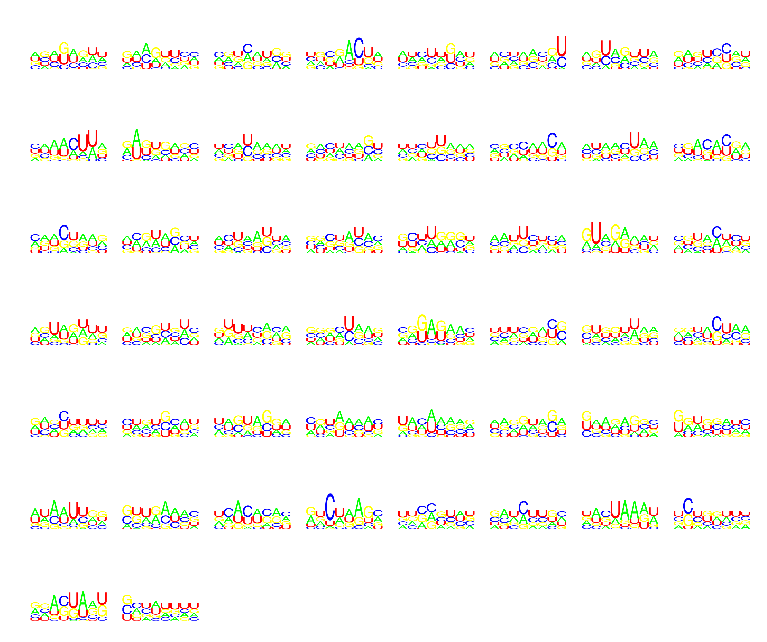

In [9]:
# plot convolutional filter --> sequence logo
W = get_weights(network['conv1'], convert_pwm=1)

num_filters = W.shape[0]
nrows = np.ceil(np.sqrt(num_filters)).astype(int)
ncols = nrows
height=300
bp_width=50
adjust=-1.5,
size = (100.0, 100.0)
fig = plt.figure(figsize=size)
fig.set_size_inches(size[0],size[1], forward=True);
grid= mpl.gridspec.GridSpec(nrows, ncols)
grid.update(wspace=0.2, hspace=0.2, left=0.1, right=0.2, bottom=0.1, top=0.2)     
for i in range(num_filters):
    plt.subplot(grid[i])

    MIN = np.min(W[i])
    MAX = np.max(W[i])
    pwm = (W[i] - MIN)/(MAX-MIN)
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm
    num_seq = pwm.shape[1]
    width = bp_width*num_seq
    logo = seq_logo(pwm, height, width, norm=0, rna=1, filepath='.')
    plt.imshow(logo, cmap='jet', vmin=0, vmax=1, interpolation='none') 
    plt.axis('off')
    
plt.savefig(os.path.join(filepath + '_layer1_motifs.eps'), format='eps',bbox_inches='tight');  

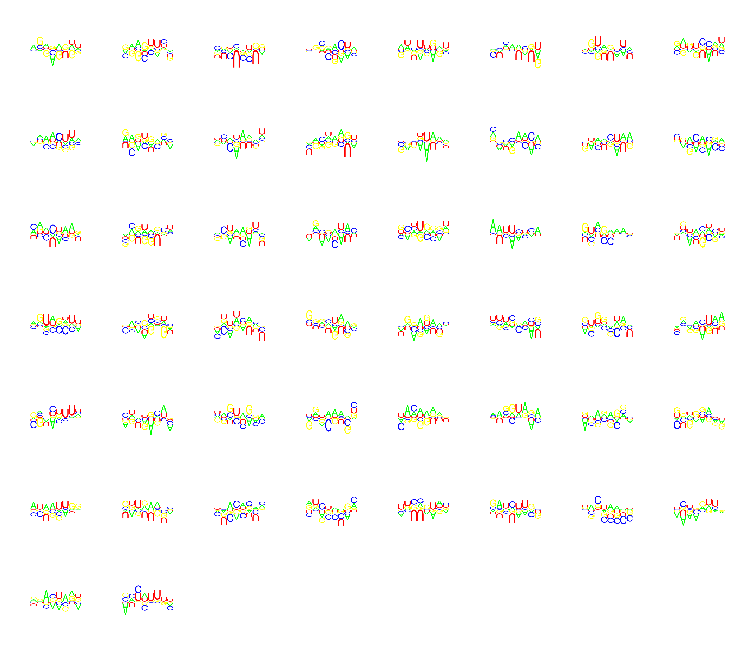

In [10]:
# plot convolutional filter --> sequence logo
W = get_weights(network['conv1'], convert_pwm=0)

num_filters = W.shape[0]
nrows = np.ceil(np.sqrt(num_filters)).astype(int)
ncols = nrows
height=300
bp_width=50
adjust=-1.5,
size = (100.0, 100.0)
fig = plt.figure(figsize=size)
fig.set_size_inches(size[0],size[1], forward=True);
grid= mpl.gridspec.GridSpec(nrows, ncols)
grid.update(wspace=0.2, hspace=0.2, left=0.1, right=0.2, bottom=0.1, top=0.2)     
for i in range(num_filters):
    plt.subplot(grid[i])
    pwm = W[i]
    num_seq = pwm.shape[1]
    width = bp_width*num_seq
    logo = seq_logo2(pwm, height, width, norm=0, rna=1, filepath='.')
    plt.imshow(logo, cmap='jet', interpolation='none') 
    plt.axis('off')
    
plt.savefig(os.path.join(filepath + '_layer1_corrmat.eps'), format='eps',bbox_inches='tight');  

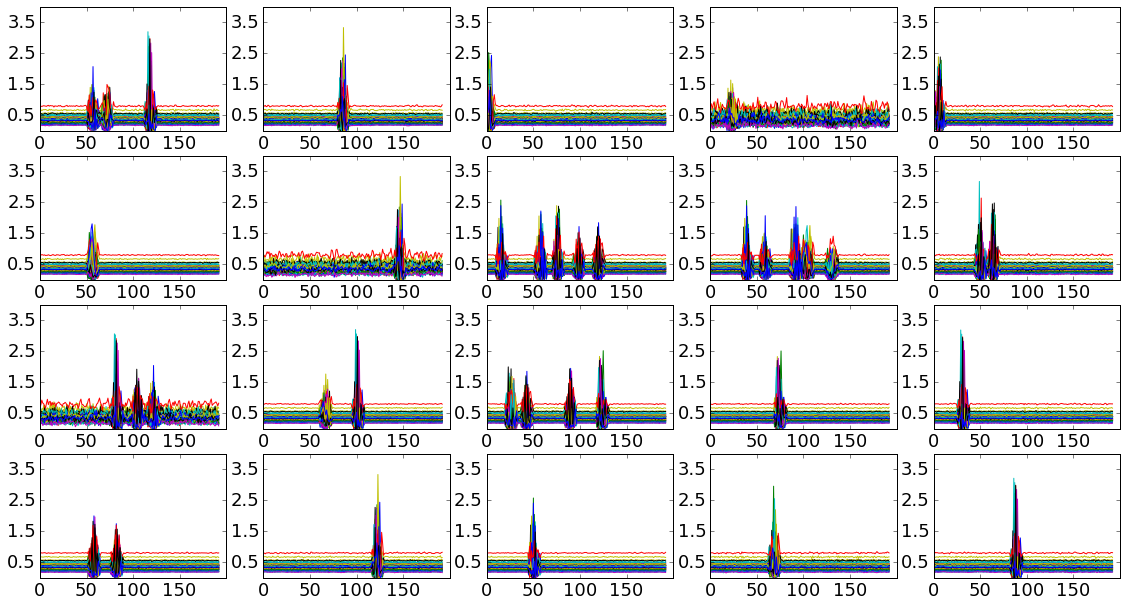

In [11]:
fmaps = get_feature_maps(network['conv1_active'], nnmodel.input_var, train[0])
mean_activation, std_activation = get_class_activation(fmaps, train[1])
options = { 'ylim': [0, 4],
            'xticks': [0, 50, 100, 150],
            'yticks': [0.5, 1.5, 2.5, 3.5], 
            'labelsize': 18,
            'figsize': (150,100)}
plt = plot_mean_activations(mean_activation, options)
plt.savefig(os.path.join(filepath + '_layer1_mean_activation.eps'), format='eps',bbox_inches='tight');  

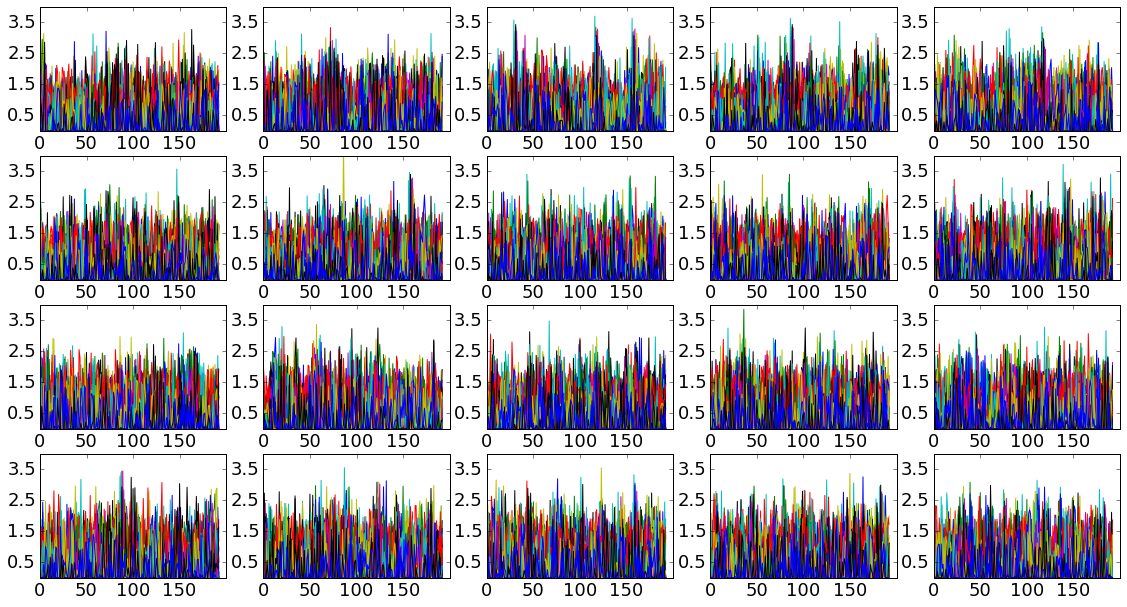

In [12]:
num_plot = 20
nrows = np.ceil(np.sqrt(num_plot)).astype(int)
ncols = nrows
options = { 'ylim': [0, 4],
            'xticks': [0, 50, 100, 150],
            'yticks': [0.5, 1.5, 2.5, 3.5], 
            'labelsize': 18,
            'figsize': (150,100)}
plt.figure()
grid = subplot_grid(nrows, ncols)
for i in range(num_plot):
    plt.subplot(grid[i])
    x = np.squeeze(fmaps[i]);
    plt.plot(x.T)
    fig_options(plt, options)

plt.savefig(os.path.join(filepath + '_layer1_activation.eps'), format='eps',bbox_inches='tight');      

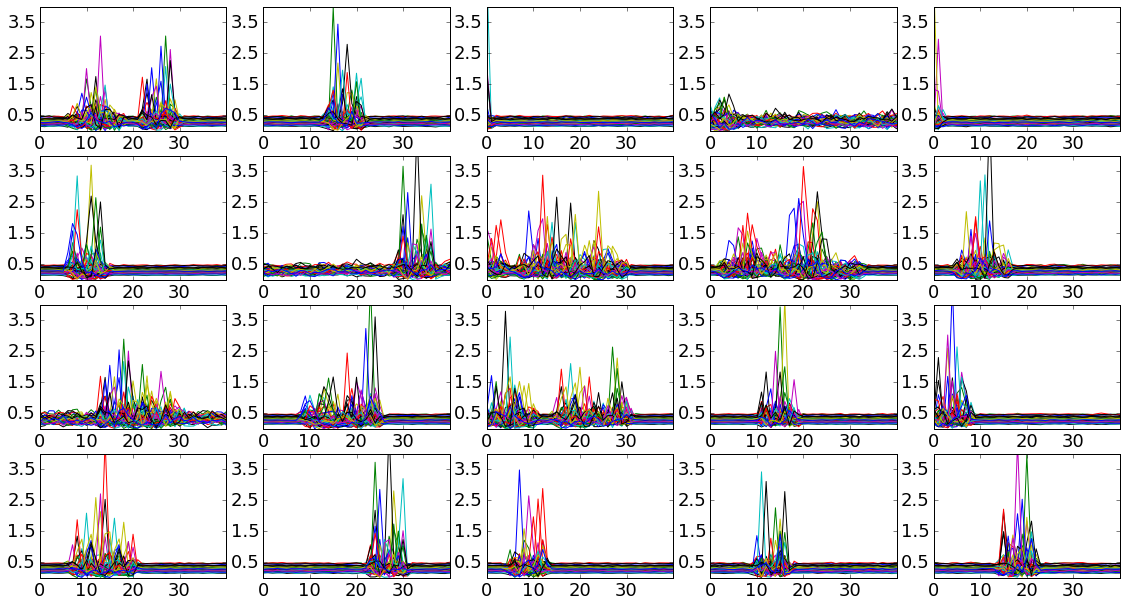

In [13]:
fmaps = get_feature_maps(network['conv2_active'], nnmodel.input_var, train[0]) 
mean_activation, std_activation = get_class_activation(fmaps, train[1])
options = { 'ylim': [0, 4],
            'xticks': [0, 10, 20, 30],
            'yticks': [0.5, 1.5, 2.5, 3.5], 
            'labelsize': 18,
            'figsize': (150,100)}
plt = plot_mean_activations(mean_activation, options)
plt.savefig(os.path.join(filepath + '_layer2_activation.eps'), format='eps',bbox_inches='tight');     

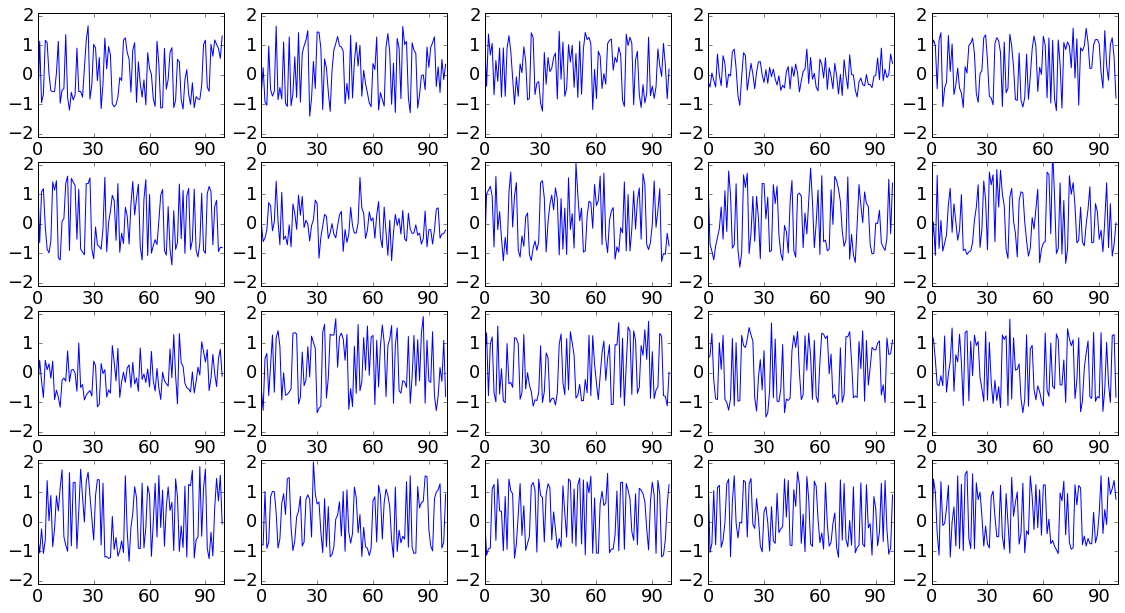

In [14]:
fmaps = get_feature_maps(network['dense_active'], nnmodel.input_var, train[0]) 
mean_activation, std_activation = get_class_activation(fmaps, train[1])
options = { 'ylim': [-2.1, 2.1],
            'xticks': [0, 30, 60, 90],
            'yticks': [-2, -1, 0, 1, 2], 
            'labelsize': 18,
            'figsize': (150,100)}
plt = plot_mean_activations(mean_activation, options)
plt.savefig(os.path.join(filepath + '_layer3_activation.eps'), format='eps',bbox_inches='tight');     

In [ ]:
fmaps = get_feature_maps(network['conv2_active'], nnmodel.input_var, train[0])
t = np.squeeze(fmaps[1])
W = get_weights(network['conv2'], convert_pwm=0)
num_filters, dim, filter_length = W.shape
seq_length = t.shape[1]
seq = np.zeros((dim, seq_length+filter_length-1))
for j in range(seq_length):
    val = 0
    for i in range(num_filters):
        val += W[i]*t[i,j]
    seq[:,range(j,j+filter_length)] = val

print W.shape
print t.shape
print seq.shape

In [ ]:
pool_size = 4
num_filters, seq_length = seq.shape
seq_unpool = np.zeros((num_filters, seq_length*pool_size))
for i in range(seq_length):
    seq_unpool[:,range(i*pool_size,(i+1)*pool_size)] = np.outer(seq[:,i],np.ones((1,pool_size)))


In [ ]:
plt.plot(seq_unpool.T);

In [ ]:
network

In [15]:
if network['conv1_bias'].b:
    b = network['conv1_bias'].b.get_value()

In [19]:
fmaps = get_feature_maps(network['conv1_active'], nnmodel.input_var, train[0])
t = np.squeeze(fmaps[1])
W =  np.squeeze(network['conv1'].W.get_value())
    
W = get_weights(network['conv1'], convert_pwm=0)
num_filters, dim, filter_length = W.shape
seq_length = t.shape[1]
seq = np.zeros((dim, seq_length+filter_length-1))
for j in range(seq_length):
    val = 0
    for i in range(num_filters):
        val += W[i]*t[i,j]
    seq[:,range(j,j+filter_length)] = val
print W.shape
print t.shape
print seq.shape    

(50, 4, 8)
(50, 193)
(4, 200)


In [ ]:
W.shape

In [20]:
j=1
print np.linalg.pinv(W[j])
print W[j]    

[[-1.14146614 -1.40765381 -0.39208835  0.07483721]
 [ 0.91776764 -2.01195526 -1.32703972  0.87699592]
 [ 2.12705088 -1.04425442 -1.44529617  0.01930366]
 [ 0.72122008 -2.19410086  0.488718   -0.4964745 ]
 [ 2.24088335 -2.57177377  0.30333582  2.89750409]
 [-3.27368212 -0.48203266 -1.76735187  1.92436862]
 [ 2.28070354  2.75456643  2.45635366  1.09659874]
 [-3.12038469 -2.34672499 -2.93071318 -1.09420943]]
[[-0.0683087   0.07284049  0.172391   -0.03403385  0.01512411 -0.09713747
   0.02561308 -0.0329236 ]
 [-0.09298911 -0.00815588  0.08074002 -0.18126553 -0.1061419   0.05612767
   0.07826641 -0.03314615]
 [ 0.11037564 -0.11546011 -0.26563346  0.19938214  0.07238434 -0.06232662
   0.02258028 -0.0754496 ]
 [-0.00165638  0.03830529 -0.01962375 -0.08425488  0.14685626  0.1854205
   0.07523746 -0.05505302]]


In [ ]:
fmaps = get_feature_maps(network['conv1_pool'], nnmodel.input_var, train[0])
fmaps_flat = fmaps.reshape((len(fmaps),-1))
fmaps_flat.shape

In [ ]:
# perform t-SNE embedding
from tsne import bh_sne
vis_cnn = bh_sne(fmaps_flat)

In [ ]:
options = {'figsize':(5,5), 'axis':'off'}
tSNE_plot(vis_cnn, train[1])
plt.savefig('categorical_tsne_layer1_'+ str(1) +'.eps', format='eps', dpi=1000)